# Tranformacion de los datos

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
import statsmodels.api as sm
import scipy.stats as stats


In [3]:
datasets = ['city_day', 'city_hour', 'station_day', 'station_hour', 'stations']
dataframes = {}
for dataset in datasets:
    print('Cargando', dataset)
    df = pd.read_csv(f'../data/landing-zone/{dataset}.csv')
    dataframes[dataset] = df
    print('Cargado', dataset)

Cargando city_day
Cargado city_day
Cargando city_hour
Cargado city_hour
Cargando station_day
Cargado station_day
Cargando station_hour


C:\Users\diego\AppData\Local\Temp\ipykernel_28540\2145442023.py:5: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../data/landing-zone/{dataset}.csv')


Cargado station_hour
Cargando stations
Cargado stations


In [4]:
city_day = dataframes['city_day']

In [5]:
# Mostrar las primeras filas
print(city_day.head())

# Resumen de valores faltantes
missing_summary = city_day.isnull().sum()
missing_percentage = (city_day.isnull().sum() / len(city_day)) * 100

# Mostrar resumen
missing_data = pd.DataFrame({
    'Valores Faltantes': missing_summary,
    'Porcentaje (%)': missing_percentage
})
print(missing_data.sort_values(by='Porcentaje (%)', ascending=False))


        City        Date  PM2.5  PM10     NO    NO2    NOx  NH3     CO    SO2  \
0  Ahmedabad  2015-01-01    NaN   NaN   0.92  18.22  17.15  NaN   0.92  27.64   
1  Ahmedabad  2015-01-02    NaN   NaN   0.97  15.69  16.46  NaN   0.97  24.55   
2  Ahmedabad  2015-01-03    NaN   NaN  17.40  19.30  29.70  NaN  17.40  29.07   
3  Ahmedabad  2015-01-04    NaN   NaN   1.70  18.48  17.97  NaN   1.70  18.59   
4  Ahmedabad  2015-01-05    NaN   NaN  22.10  21.42  37.76  NaN  22.10  39.33   

       O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
0  133.36     0.00     0.02    0.00  NaN        NaN  
1   34.06     3.68     5.50    3.77  NaN        NaN  
2   30.70     6.80    16.40    2.25  NaN        NaN  
3   36.08     4.43    10.14    1.00  NaN        NaN  
4   39.31     7.01    18.89    2.78  NaN        NaN  
            Valores Faltantes  Porcentaje (%)
Xylene                  18109       61.322001
PM10                    11140       37.723071
NH3                     10328       34.973418
Tolue

Revisando el reporte para city_day tenemos bastantes datos faltantes en las siguientes columnas:

- Xylene: 61.32% 
- PM10: 37.72% 
- NH3: 34.97%
- Toluene: 27.23% 
- Benzene: 19.04% 
- AQI y AQI_Bucket: 15.85% 
- PM2.5: 15.57% 
- NOx, O3, SO2, NO2, NO, CO: Entre 6% y 14%

## Estrategia
Primero analizare la correlacion entre las variables para ver si puedo inferir los valores faltantes de alguna manera.

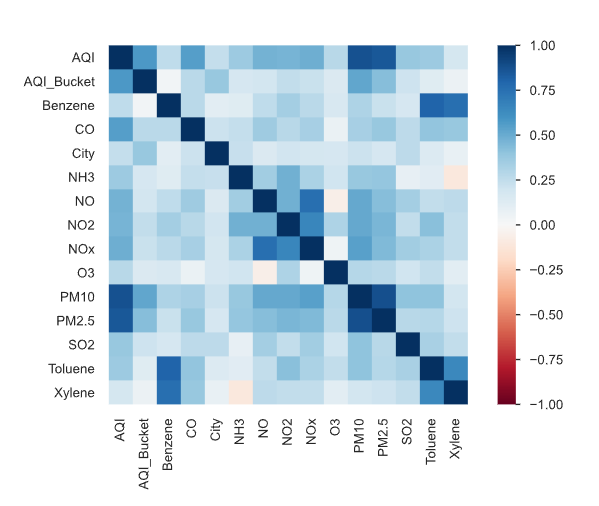
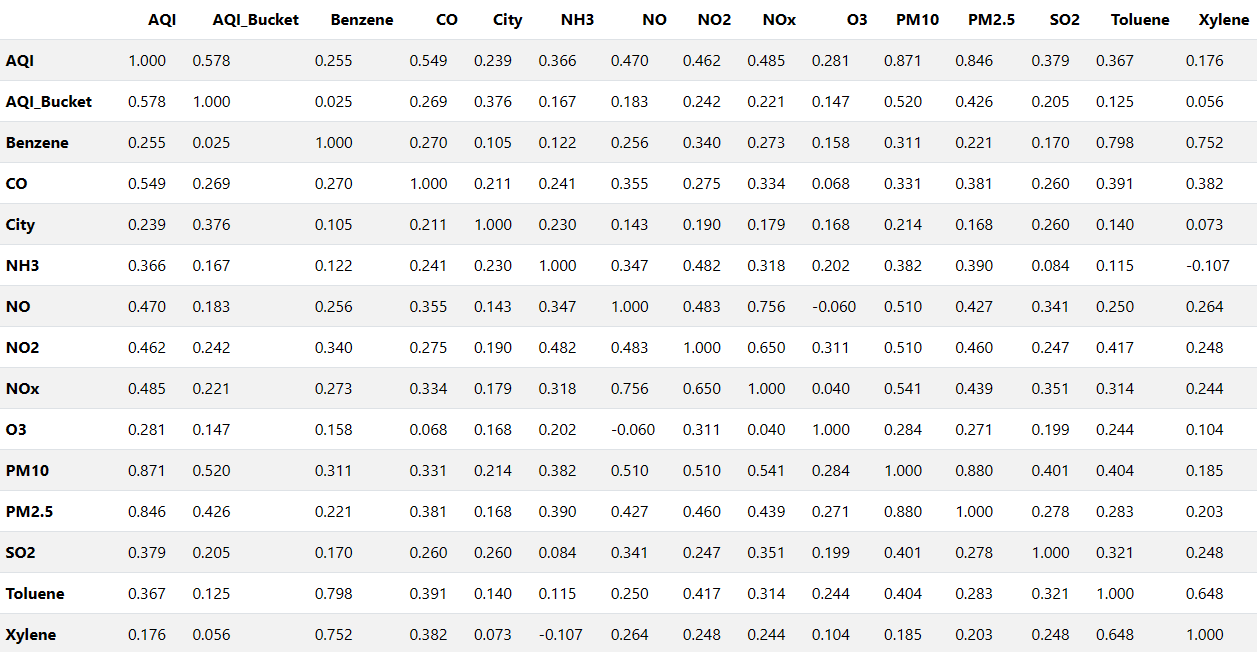

Como se observa en las imagenes las siguientes variables tienen una correlacion alta:
- PM2.5 y PM10 tienen una correlacion de 0.88
- PM10 y AQI tienen una correlacion de 0.87
- Benzene y Toluene tienen una correlacion de 0.8
Por lo que se puede inferir los valores faltantes de las variables PM10, AQI, NOx y Toluene.

In [6]:
# Imputar PM 2.5 con la media
city_day['PM2.5'] = city_day['PM2.5'].fillna(city_day['PM2.5'].mean())

In [7]:
# Verificar si se imputaron los valores faltantes
missing_summary = city_day.isnull().sum()
missing_percentage = (city_day.isnull().sum() / len(city_day)) * 100
print(missing_summary)
print(missing_percentage)

City              0
Date              0
PM2.5             0
PM10          11140
NO             3582
NO2            3585
NOx            4185
NH3           10328
CO             2059
SO2            3854
O3             4022
Benzene        5623
Toluene        8041
Xylene        18109
AQI            4681
AQI_Bucket     4681
dtype: int64
City           0.000000
Date           0.000000
PM2.5          0.000000
PM10          37.723071
NO            12.129626
NO2           12.139785
NOx           14.171549
NH3           34.973418
CO             6.972334
SO2           13.050692
O3            13.619586
Benzene       19.041008
Toluene       27.229014
Xylene        61.322001
AQI           15.851139
AQI_Bucket    15.851139
dtype: float64


In [8]:
# Filtrar columnas de interés
columns_of_interest = ['PM2.5', 'PM10', 'AQI']
filtered_data = city_day[columns_of_interest]

# Matriz de correlación
correlation_matrix = filtered_data.corr()
print("Matriz de Correlación:")
print(correlation_matrix)


Matriz de Correlación:
          PM2.5      PM10       AQI
PM2.5  1.000000  0.817797  0.654743
PM10   0.817797  1.000000  0.803313
AQI    0.654743  0.803313  1.000000


In [9]:
#Test de hipotesis para la correlacion entre PM2.5 y PM10
# H0: La correlación entre PM2.5 y PM10 es igual a 0
# H1: La correlación entre PM2.5 y PM10 es diferente de 0
alpha = 0.001

# Eliminar filas con valores NaN en las columnas PM2.5 y PM10
filtered_city_day = city_day[['PM2.5', 'PM10']].dropna()

corr, p_value = stats.pearsonr(filtered_city_day['PM2.5'], filtered_city_day['PM10'])
print("Correlación entre PM2.5 y PM10:", corr)
print("P-Value:", p_value)
if p_value < alpha:
    print("Se rechaza la hipótesis nula")
else:
    print("La hipótesis nula no se puede rechazar")
    

Correlación entre PM2.5 y PM10: 0.8177973068297985
P-Value: 0.0
Se rechaza la hipótesis nula


## Tenemos una correlacion muy alta y por ende podemos inferir los valores faltantes de las siguientes variables:

In [10]:
from sklearn.linear_model import LinearRegression

# Filtrar datos completos y faltantes
complete_rows = city_day.dropna(subset=['PM2.5', 'PM10'])
missing_rows = city_day[city_day['PM10'].isnull() & city_day['PM2.5'].notnull()]

if not missing_rows.empty:
    # Modelo de regresión
    regressor = LinearRegression()
    regressor.fit(complete_rows[['PM2.5']], complete_rows['PM10'])

    # Predicción de valores faltantes
    predictions = regressor.predict(missing_rows[['PM2.5']])
    
    # Actualizar valores imputados
    city_day.loc[missing_rows.index, 'PM10'] = predictions
    print("Imputación completa de PM10.")

else:
    print("No hay filas con valores faltantes en PM10 para imputar.")


Imputación completa de PM10.


Valores faltantes en PM10 después de la imputación: 0


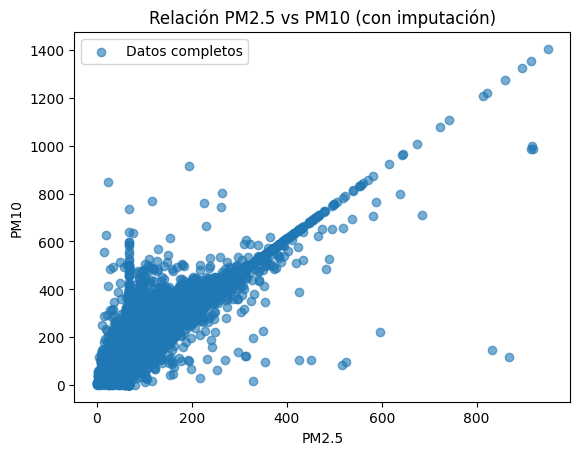

In [11]:
# Verificar valores faltantes
print("Valores faltantes en PM10 después de la imputación:", city_day['PM10'].isnull().sum())

# Visualización de la relación imputada
import matplotlib.pyplot as plt

plt.scatter(city_day['PM2.5'], city_day['PM10'], label='Datos completos', alpha=0.6)
plt.xlabel('PM2.5')
plt.ylabel('PM10')
plt.title('Relación PM2.5 vs PM10 (con imputación)')
plt.legend()
plt.show()


In [12]:
# Ahora vemos los demas datos faltantes
# Resumen de valores faltantes
missing_summary = city_day.isnull().sum()
missing_percentage = (city_day.isnull().sum() / len(city_day)) * 100
print(missing_summary)
print(missing_percentage)

City              0
Date              0
PM2.5             0
PM10              0
NO             3582
NO2            3585
NOx            4185
NH3           10328
CO             2059
SO2            3854
O3             4022
Benzene        5623
Toluene        8041
Xylene        18109
AQI            4681
AQI_Bucket     4681
dtype: int64
City           0.000000
Date           0.000000
PM2.5          0.000000
PM10           0.000000
NO            12.129626
NO2           12.139785
NOx           14.171549
NH3           34.973418
CO             6.972334
SO2           13.050692
O3            13.619586
Benzene       19.041008
Toluene       27.229014
Xylene        61.322001
AQI           15.851139
AQI_Bucket    15.851139
dtype: float64


In [13]:
# Ahora vamos a imputar los valores faltantes de AQI
# Filtrar datos completos y faltantes
complete_rows = city_day.dropna(subset=['PM2.5', 'PM10', 'AQI'])
missing_rows = city_day[city_day['AQI'].isnull() & city_day['PM10'].notnull() & city_day['PM2.5'].notnull()]

if not missing_rows.empty:
    # Modelo de regresión
    regressor = LinearRegression()
    regressor.fit(complete_rows[['PM2.5', 'PM10']], complete_rows['AQI'])

    # Predicción de valores faltantes
    predictions = regressor.predict(missing_rows[['PM2.5', 'PM10']])
    
    # Actualizar valores imputados
    city_day.loc[missing_rows.index, 'AQI'] = predictions
    print("Imputación completa de AQI.")
    

Imputación completa de AQI.


In [14]:
# Verificar valores faltantes
print("Valores faltantes en AQI después de la imputación:", city_day['AQI'].isnull().sum())

Valores faltantes en AQI después de la imputación: 0


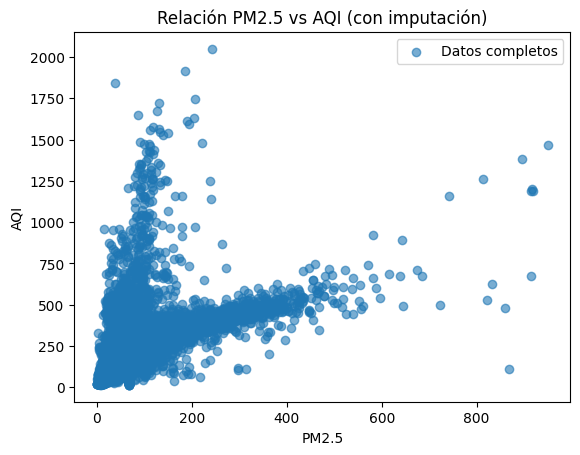

In [15]:
# Visualización de la relación imputada
import matplotlib.pyplot as plt

plt.scatter(city_day['PM2.5'], city_day['AQI'], label='Datos completos', alpha=0.6)
plt.xlabel('PM2.5')
plt.ylabel('AQI')
plt.title('Relación PM2.5 vs AQI (con imputación)')
plt.legend()
plt.show()

In [16]:
# Ahora vamos a imputar los valores faltantes de NO2 con KMeans
# Filtrar datos completos y faltantes
complete_rows = city_day.dropna(subset=['NO2'])
missing_rows = city_day[city_day['NO2'].isnull()]

if not missing_rows.empty:
    # Entrenar modelo KMeans
    kmeans = KMeans(n_clusters=3, random_state=0)
    kmeans.fit(complete_rows[['PM2.5', 'PM10', 'AQI']])
    
    # Predecir valores faltantes
    predictions = kmeans.predict(missing_rows[['PM2.5', 'PM10', 'AQI']])
    
    # Actualizar valores imputados
    city_day.loc[missing_rows.index, 'NO2'] = predictions
    print("Imputación completa de NO2.")
else:
    print("No hay filas con valores faltantes en NO2 para imputar.")

Imputación completa de NO2.


In [17]:
# Verificar valores faltantes
print("Valores faltantes en NO2 después de la imputación:", city_day['NO2'].isnull().sum())


Valores faltantes en NO2 después de la imputación: 0


In [18]:
# Ahora vamos a imputar los valores faltantes de SO2 con KMeans
# Filtrar datos completos y faltantes
complete_rows = city_day.dropna(subset=['SO2'])
missing_rows = city_day[city_day['SO2'].isnull()]

if not missing_rows.empty:
    # Entrenar modelo KMeans
    kmeans = KMeans(n_clusters=3, random_state=0)
    kmeans.fit(complete_rows[['PM2.5', 'PM10', 'AQI']])
    
    # Predecir valores faltantes
    predictions = kmeans.predict(missing_rows[['PM2.5', 'PM10', 'AQI']])
    
    # Actualizar valores imputados
    city_day.loc[missing_rows.index, 'SO2'] = predictions
    print("Imputación completa de SO2.")
else:
    print("No hay filas con valores faltantes en SO2 para imputar.")


Imputación completa de SO2.


In [19]:
# Verificar valores faltantes
print("Valores faltantes en SO2 después de la imputación:", city_day['SO2'].isnull().sum())

Valores faltantes en SO2 después de la imputación: 0


In [20]:
# Ahora verificamos los datos faltantes
# Resumen de valores faltantes
missing_summary = city_day.isnull().sum()
missing_percentage = (city_day.isnull().sum() / len(city_day)) * 100
print(missing_summary)
print(missing_percentage)

City              0
Date              0
PM2.5             0
PM10              0
NO             3582
NO2               0
NOx            4185
NH3           10328
CO             2059
SO2               0
O3             4022
Benzene        5623
Toluene        8041
Xylene        18109
AQI               0
AQI_Bucket     4681
dtype: int64
City           0.000000
Date           0.000000
PM2.5          0.000000
PM10           0.000000
NO            12.129626
NO2            0.000000
NOx           14.171549
NH3           34.973418
CO             6.972334
SO2            0.000000
O3            13.619586
Benzene       19.041008
Toluene       27.229014
Xylene        61.322001
AQI            0.000000
AQI_Bucket    15.851139
dtype: float64


In [21]:
# Ahora vamos a imputar los valores faltantes de CO con KMeans y AQI
# Filtrar datos completos y faltantes
complete_rows = city_day.dropna(subset=['CO'])
missing_rows = city_day[city_day['CO'].isnull()]

if not missing_rows.empty:
    # Entrenar modelo KMeans
    kmeans = KMeans(n_clusters=3, random_state=0)
    kmeans.fit(complete_rows[['PM2.5', 'PM10', 'AQI']])
    
    # Predecir valores faltantes
    predictions = kmeans.predict(missing_rows[['PM2.5', 'PM10', 'AQI']])
    
    # Actualizar valores imputados
    city_day.loc[missing_rows.index, 'CO'] = predictions
    print("Imputación completa de CO.")
else:
    print("No hay filas con valores faltantes en CO para imputar.")
    

Imputación completa de CO.


In [22]:
# Verificar valores faltantes
print("Valores faltantes en CO después de la imputación:", city_day['CO'].isnull().sum())

Valores faltantes en CO después de la imputación: 0


In [23]:
# Ahora vamos a imputar los valores faltantes de O3 con KMeans
# Filtrar datos completos y faltantes
complete_rows = city_day.dropna(subset=['O3'])
missing_rows = city_day[city_day['O3'].isnull()]

if not missing_rows.empty:
    # Entrenar modelo KMeans
    kmeans = KMeans(n_clusters=3, random_state=0)
    kmeans.fit(complete_rows[['PM2.5', 'PM10', 'AQI']])
    
    # Predecir valores faltantes
    predictions = kmeans.predict(missing_rows[['PM2.5', 'PM10', 'AQI']])
    
    # Actualizar valores imputados
    city_day.loc[missing_rows.index, 'O3'] = predictions
    print("Imputación completa de O3.")
else:
    print("No hay filas con valores faltantes en O3 para imputar.")
    

Imputación completa de O3.


In [24]:
# Verificar valores faltantes
print("Valores faltantes en O3 después de la imputación:", city_day['O3'].isnull().sum())

Valores faltantes en O3 después de la imputación: 0


In [25]:
# Ahora vamos a imputar los valores faltantes de Benzene con KMeans
# Filtrar datos completos y faltantes
complete_rows = city_day.dropna(subset=['Benzene'])
missing_rows = city_day[city_day['Benzene'].isnull()]

if not missing_rows.empty:
    # Entrenar modelo KMeans
    kmeans = KMeans(n_clusters=3, random_state=0)
    kmeans.fit(complete_rows[['PM2.5', 'PM10', 'AQI']])
    
    # Predecir valores faltantes
    predictions = kmeans.predict(missing_rows[['PM2.5', 'PM10', 'AQI']])
    
    # Actualizar valores imputados
    city_day.loc[missing_rows.index, 'Benzene'] = predictions
    print("Imputación completa de Benzene.")
else:
    print("No hay filas con valores faltantes en Benzene para imputar.")

Imputación completa de Benzene.


In [26]:
# Verificar valores faltantes
print("Valores faltantes en Benzene después de la imputación:", city_day['Benzene'].isnull().sum())

Valores faltantes en Benzene después de la imputación: 0


In [27]:
# Ahora vamos a imputar los valores faltantes de Toluene con KMeans y Benzene
# Filtrar datos completos y faltantes
complete_rows = city_day.dropna(subset=['Toluene'])
missing_rows = city_day[city_day['Toluene'].isnull()]

if not missing_rows.empty:
    # Entrenar modelo KMeans
    kmeans = KMeans(n_clusters=3, random_state=0)
    kmeans.fit(complete_rows[['PM2.5', 'PM10', 'AQI', 'Benzene']])
    
    # Predecir valores faltantes
    predictions = kmeans.predict(missing_rows[['PM2.5', 'PM10', 'AQI', 'Benzene']])
    
    # Actualizar valores imputados
    city_day.loc[missing_rows.index, 'Toluene'] = predictions
    print("Imputación completa de Toluene.")
else:
    print("No hay filas con valores faltantes en Toluene para imputar.")

Imputación completa de Toluene.


In [28]:
# Verificar valores faltantes
print("Valores faltantes en Toluene después de la imputación:", city_day['Toluene'].isnull().sum())

Valores faltantes en Toluene después de la imputación: 0


In [29]:
# Ahora vamos a imputar los valores faltantes de Xylene con KMeans y Benzene y Toluene
# Filtrar datos completos y faltantes
complete_rows = city_day.dropna(subset=['Xylene'])
missing_rows = city_day[city_day['Xylene'].isnull()]

if not missing_rows.empty:
    # Entrenar modelo KMeans
    kmeans = KMeans(n_clusters=3, random_state=0)
    kmeans.fit(complete_rows[['PM2.5', 'PM10', 'AQI', 'Benzene', 'Toluene']])
    
    # Predecir valores faltantes
    predictions = kmeans.predict(missing_rows[['PM2.5', 'PM10', 'AQI', 'Benzene', 'Toluene']])
    
    # Actualizar valores imputados
    city_day.loc[missing_rows.index, 'Xylene'] = predictions
    print("Imputación completa de Xylene.")
else:
    print("No hay filas con valores faltantes en Xylene para imputar.")

Imputación completa de Xylene.


In [30]:
# Verificar valores faltantes
print("Valores faltantes en Xylene después de la imputación:", city_day['Xylene'].isnull().sum())

Valores faltantes en Xylene después de la imputación: 0


In [31]:
# Ahora verificamos los datos faltantes
# Resumen de valores faltantes
missing_summary = city_day.isnull().sum()

# Mostrar resumen
print(missing_summary)

City              0
Date              0
PM2.5             0
PM10              0
NO             3582
NO2               0
NOx            4185
NH3           10328
CO                0
SO2               0
O3                0
Benzene           0
Toluene           0
Xylene            0
AQI               0
AQI_Bucket     4681
dtype: int64


In [32]:
# Ahora hacemos la imputacion de los datos faltantes de NO con KMeans
# Filtrar datos completos y faltantes
complete_rows = city_day.dropna(subset=['NO'])
missing_rows = city_day[city_day['NO'].isnull()]

if not missing_rows.empty:
    # Entrenar modelo KMeans
    kmeans = KMeans(n_clusters=3, random_state=0)
    kmeans.fit(complete_rows[['PM2.5', 'PM10', 'AQI', 'NO2', 'SO2', 'CO', 'O3', 'Benzene', 'Toluene', 'Xylene']])
    
    # Predecir valores faltantes
    predictions = kmeans.predict(missing_rows[['PM2.5', 'PM10', 'AQI', 'NO2', 'SO2', 'CO', 'O3', 'Benzene', 'Toluene', 'Xylene']])
    
    # Actualizar valores imputados
    city_day.loc[missing_rows.index, 'NO'] = predictions
    print("Imputación completa de NO.")
else:
    print("No hay filas con valores faltantes en NO para imputar.")

Imputación completa de NO.


In [33]:
# Verificar valores faltantes
print("Valores faltantes en NO después de la imputación:", city_day['NO'].isnull().sum())

Valores faltantes en NO después de la imputación: 0


In [34]:
# Ahora vaamos a imputar los datos faltantes de NOx con KMeans
# Filtrar datos completos y faltantes
complete_rows = city_day.dropna(subset=['NOx'])
missing_rows = city_day[city_day['NOx'].isnull()]

if not missing_rows.empty:
    # Entrenar modelo KMeans
    kmeans = KMeans(n_clusters=3, random_state=0)
    kmeans.fit(complete_rows[['PM2.5', 'PM10', 'AQI', 'NO', 'NO2', 'SO2', 'CO', 'O3', 'Benzene', 'Toluene', 'Xylene']])
    
    # Predecir valores faltantes
    predictions = kmeans.predict(missing_rows[['PM2.5', 'PM10', 'AQI', 'NO', 'NO2', 'SO2', 'CO', 'O3', 'Benzene', 'Toluene', 'Xylene']])
    
    # Actualizar valores imputados
    city_day.loc[missing_rows.index, 'NOx'] = predictions
    print("Imputación completa de NOx.")
else:
    print("No hay filas con valores faltantes en NOx para imputar.")
    

Imputación completa de NOx.


In [35]:
# Ahora vamos a imputar los valores faltantes de NH3 con KMeans
# Filtrar datos completos y faltantes
complete_rows = city_day.dropna(subset=['NH3'])
missing_rows = city_day[city_day['NH3'].isnull()]

if not missing_rows.empty:
    # Entrenar modelo KMeans
    kmeans = KMeans(n_clusters=3, random_state=0)
    kmeans.fit(complete_rows[['PM2.5', 'PM10', 'AQI', 'NO', 'NO2', 'SO2', 'CO', 'O3', 'Benzene', 'Toluene', 'Xylene', 'NOx']])
    
    # Predecir valores faltantes
    predictions = kmeans.predict(missing_rows[['PM2.5', 'PM10', 'AQI', 'NO', 'NO2', 'SO2', 'CO', 'O3', 'Benzene', 'Toluene', 'Xylene', 'NOx']])
    
    # Actualizar valores imputados
    city_day.loc[missing_rows.index, 'NH3'] = predictions
    print("Imputación completa de NH3.")
else:
    print("No hay filas con valores faltantes en NH3 para imputar.")

Imputación completa de NH3.


In [36]:
# Ahora vamos a imputar los valores faltantes de AQI_Bucket con KMeans
# Filtrar datos completos y faltantes
complete_rows = city_day.dropna(subset=['AQI_Bucket'])
missing_rows = city_day[city_day['AQI_Bucket'].isnull()]

if not missing_rows.empty:
    # Entrenar modelo KMeans
    kmeans = KMeans(n_clusters=3, random_state=0)
    kmeans.fit(complete_rows[['PM2.5', 'PM10', 'AQI', 'NO', 'NO2', 'SO2', 'CO', 'O3', 'Benzene', 'Toluene', 'Xylene', 'NOx', 'NH3']])
    
    # Predecir valores faltantes
    predictions = kmeans.predict(missing_rows[['PM2.5', 'PM10', 'AQI', 'NO', 'NO2', 'SO2', 'CO', 'O3', 'Benzene', 'Toluene', 'Xylene', 'NOx', 'NH3']])
    
    # Actualizar valores imputados
    city_day.loc[missing_rows.index, 'AQI_Bucket'] = predictions
    print("Imputación completa de AQI_Bucket.")
else:
    print("No hay filas con valores faltantes en AQI_Bucket para imputar.")

Imputación completa de AQI_Bucket.


In [37]:
city_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       29531 non-null  float64
 3   PM10        29531 non-null  float64
 4   NO          29531 non-null  float64
 5   NO2         29531 non-null  float64
 6   NOx         29531 non-null  float64
 7   NH3         29531 non-null  float64
 8   CO          29531 non-null  float64
 9   SO2         29531 non-null  float64
 10  O3          29531 non-null  float64
 11  Benzene     29531 non-null  float64
 12  Toluene     29531 non-null  float64
 13  Xylene      29531 non-null  float64
 14  AQI         29531 non-null  float64
 15  AQI_Bucket  29531 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB


In [40]:
# Install pyarrow for parquet support
%pip install pyarrow

# Create a mapping dictionary for AQI_Bucket categories
aqi_bucket_mapping = {
	'Good': 0,
	'Satisfactory': 1,
	'Moderate': 2,
	'Poor': 3,
	'Very Poor': 4,
	'Severe': 5
}

# Create a copy of the dataframe
city_day_encoded = city_day.copy()

# Convert AQI_Bucket to numeric values
city_day_encoded['AQI_Bucket'] = city_day['AQI_Bucket'].map(aqi_bucket_mapping)

# Save the encoded dataset as parquet
city_day_encoded.to_parquet('../data/refined-zone/city_day.parquet', index=False)

# Save the mapping dictionary for future reference
import json
with open('../data/refined-zone/aqi_bucket_mapping.json', 'w') as f:
	json.dump(aqi_bucket_mapping, f)


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [44]:
# Process each dataset
for dataset_name in ['city_hour', 'station_day', 'station_hour', 'stations']:
    print(f"\nProcessing {dataset_name}...")
    df = dataframes[dataset_name]
    
    # Skip processing if it's the stations dataset (it doesn't have pollution data)
    if dataset_name == 'stations':
        df.to_parquet(f'../data/refined-zone/{dataset_name}.parquet', index=False)
        print(f"Saved {dataset_name} to parquet")
        continue
    
    # 1. Fill PM2.5 with mean if column exists
    if 'PM2.5' in df.columns:
        df['PM2.5'] = df['PM2.5'].fillna(df['PM2.5'].mean())
    
    # 2. Impute PM10 using Linear Regression with PM2.5
    complete_rows = df.dropna(subset=['PM2.5', 'PM10'])
    missing_rows = df[df['PM10'].isnull() & df['PM2.5'].notnull()]
    
    if not missing_rows.empty:
        regressor = LinearRegression()
        regressor.fit(complete_rows[['PM2.5']], complete_rows['PM10'])
        predictions = regressor.predict(missing_rows[['PM2.5']])
        df.loc[missing_rows.index, 'PM10'] = predictions
    
    # 3. Impute AQI using PM2.5 and PM10
    complete_rows = df.dropna(subset=['PM2.5', 'PM10', 'AQI'])
    missing_rows = df[df['AQI'].isnull() & df['PM10'].notnull() & df['PM2.5'].notnull()]
    
    if not missing_rows.empty:
        regressor = LinearRegression()
        regressor.fit(complete_rows[['PM2.5', 'PM10']], complete_rows['AQI'])
        predictions = regressor.predict(missing_rows[['PM2.5', 'PM10']])
        df.loc[missing_rows.index, 'AQI'] = predictions
    
    # 4. Impute other pollutants using KMeans
    for pollutant in ['NO2', 'SO2', 'CO', 'O3', 'NO', 'NOx', 'NH3', 'Benzene', 'Toluene', 'Xylene']:
        complete_rows = df.dropna(subset=[pollutant])
        missing_rows = df[df[pollutant].isnull()]
        
        if not missing_rows.empty:
            kmeans = KMeans(n_clusters=3, random_state=0)
            kmeans.fit(complete_rows[['PM2.5', 'PM10', 'AQI']])
            predictions = kmeans.predict(missing_rows[['PM2.5', 'PM10', 'AQI']])
            df.loc[missing_rows.index, pollutant] = predictions
    
    # 5. Map AQI_Bucket to numeric values
    if 'AQI_Bucket' in df.columns:
        df['AQI_Bucket'] = df['AQI_Bucket'].map(aqi_bucket_mapping)
    
    # Save the processed dataset
    df.to_parquet(f'../data/refined-zone/{dataset_name}.parquet', index=False)
    print(f"Saved {dataset_name} to parquet")


Processing city_hour...
Saved city_hour to parquet

Processing station_day...
Saved station_day to parquet

Processing station_hour...
Saved station_hour to parquet

Processing stations...
Saved stations to parquet


In [47]:
%pip install pyodbc
import pandas as pd
import pyodbc
# Import necessary libraries

# Connection string
conn_str = (
    "Driver={SQL Server};"
    "Server=DIEGOUwU\\SQLEXPRESS;"
    "Database=AirQuality;"
    "Trusted_Connection=yes;"
)

# Read parquet files
parquet_files = [
    '../data/refined-zone/city_day.parquet',
    '../data/refined-zone/city_hour.parquet', 
    '../data/refined-zone/station_day.parquet',
    '../data/refined-zone/station_hour.parquet',
    '../data/refined-zone/stations.parquet'
]

# Connect to SQL Server
conn = pyodbc.connect(conn_str)
cursor = conn.cursor()

# Process each parquet file
for parquet_file in parquet_files:
    # Extract table name from file path
    table_name = parquet_file.split('/')[-1].replace('.parquet', '')
    
    # Read parquet file
    df = pd.read_parquet(parquet_file)
    
    # Create column definitions for CREATE TABLE
    columns = []
    for col, dtype in df.dtypes.items():
        sql_type = 'FLOAT' if 'float' in str(dtype) else 'VARCHAR(255)'
        columns.append(f"[{col}] {sql_type}")
    
    # Create table
    create_table = f"IF NOT EXISTS (SELECT * FROM sys.tables WHERE name = '{table_name}') CREATE TABLE {table_name} ({', '.join(columns)})"
    cursor.execute(create_table)
    
    # Insert data in batches
    batch_size = 1000
    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i+batch_size]
        
        # Create the INSERT statement
        placeholders = ','.join(['?' for _ in range(len(df.columns))])
        insert_stmt = f"INSERT INTO {table_name} VALUES ({placeholders})"
        
        # Convert DataFrame to list of tuples, replacing NaN with None (SQL NULL)
        data = []
        for row in batch.values:
            cleaned_row = [None if pd.isna(x) else x for x in row]
            data.append(tuple(cleaned_row))
        
        # Execute batch insert
        cursor.executemany(insert_stmt, data)
        conn.commit()
    
    print(f"Completed loading {table_name}")

# Close connection
cursor.close()
conn.close()



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Completed loading city_day
Completed loading city_hour
Completed loading station_day
Completed loading station_hour
Completed loading stations
